*Universidad de Chile*  
*Facultad de Ciencias Físicas y Matemáticas*  
*Departamento de Ingeniería Matemática*
 
# Laboratorio 4
**Curso:** MA4703-1 Control Óptimo: Teoría y Laboratorio  
**Profesor:** Héctor Ramírez C.  
**Auxiliares:** Javier Madariaga R. y Pablo Araya Z.   
**Alumno:** Diego Dominguez - Adrián Arellano

In [1]:
import numpy as np
import scipy as sc

import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp, quad
from scipy.optimize import minimize
import pandas as pd
from control import lqr

In [2]:
def solver(T, Y1, Y2, c, p):
    def funcion_dinamica(c):
        [Y1, Y2] = c
        
        def dinamica(t, z):
            [y1, y2, p1, p2] = z
            dzdt=[y2-Y2+p1, Y1-y1, p2, -p1]
            return dzdt

        return dinamica


    def calculo_error(p_inicial):
        [p1_0, p2_0] = p_inicial
        z_0 = [Y1, Y2 + c, p1_0, p2_0]
        cte = [Y1, Y2]

        sol = solve_ivp(funcion_dinamica(cte), t_span=[0, T], y0=z_0, rtol = 1e-10)

        [y1, y2, p1, p2] = sol.y
        var1 = y1[-1] + p1[-1]
        var2 = p2[-1]
        error = var1**2 + var2**2
        return error
    
    funcion_objetivo=lambda p_inicial: calculo_error(p_inicial)
    solucion_inicial_p_optima=minimize(funcion_objetivo, p).x
    
    cte = [Y1, Y2]
    condicion_inicial_optima=[Y1, Y2 + c]+list(solucion_inicial_p_optima)
    solucion_optima=solve_ivp(funcion_dinamica(cte), t_span=[0, T], y0=condicion_inicial_optima,dense_output=True, rtol = 1e-10)
    [y1, y2, p1, p2] = solucion_optima.y
    return [y1, y2, p1, p2], solucion_optima.t, solucion_optima

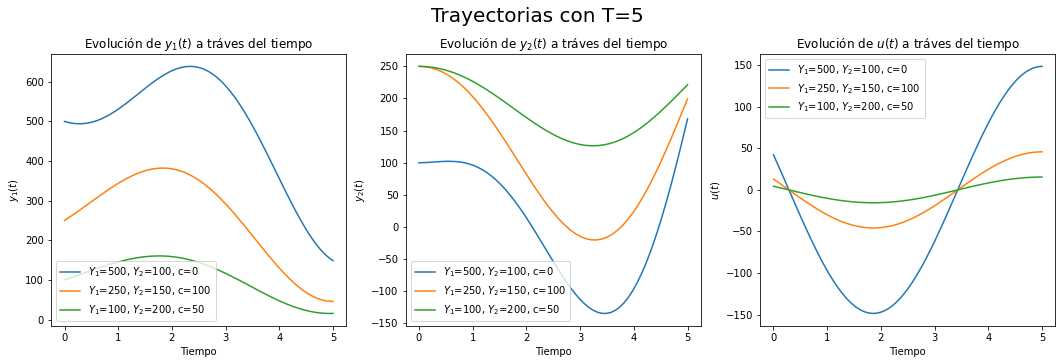

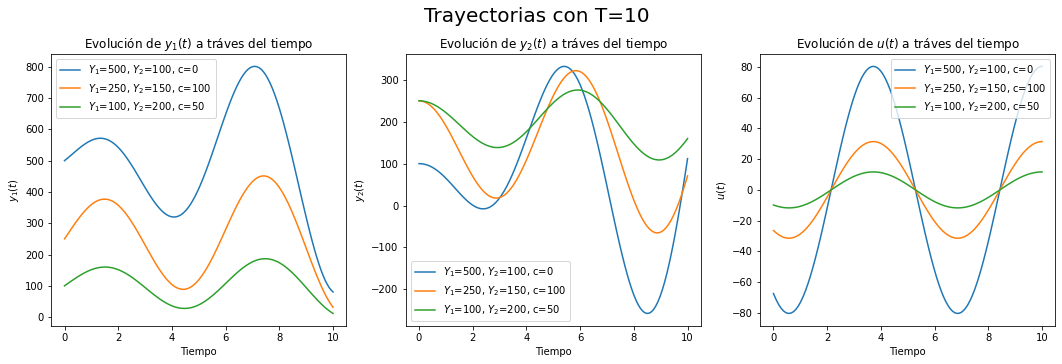

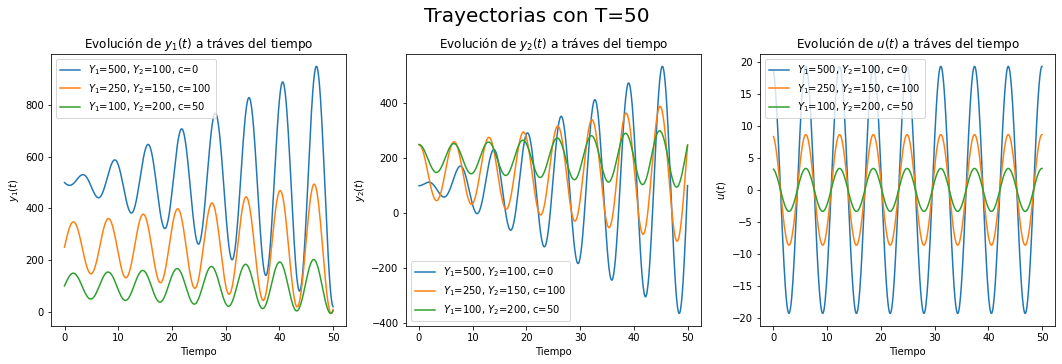

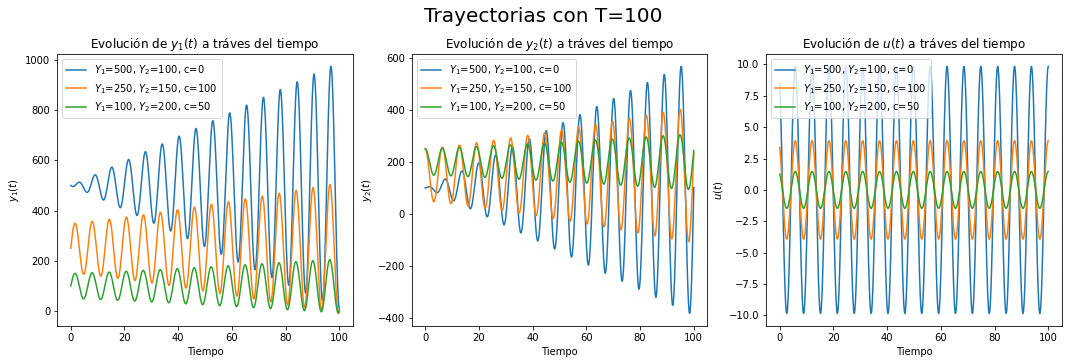

In [3]:
Ts=[5, 10, 50, 100]
constantes=[[500,100,0],[250,150,100],[100,200,50]]
Valores_objetivo={}
Errores={}
for T in Ts:
    tiempos_sol=[]
    soluciones=[]
    V_objetivo=[]
    Error_list=[]
    for Cte in constantes:
        [Y1, Y2, c] = Cte
        p = [1, 1]
        [y1, y2, p1, p2], t, solucion_optima=solver(T, Y1, Y2, c, p)
        u=-p1
        tiempos_sol.append(t)
        soluciones.append([y1, y2, u])
        
        def funcion_u(t):
            control_u=-solucion_optima.sol(t)[2] # -p_1(t)
            return control_u**2
        valor_integral=quad(funcion_u, 0, T)
        valor_objetivo=y1[-1]**2+valor_integral[0]
        error=valor_integral[1]
        V_objetivo.append(valor_objetivo)
        Error_list.append(error)
    Valores_objetivo['T='+str(T)]=V_objetivo
    Errores['T='+str(T)]=Error_list
        
    labels=['y_1(t)', 'y_2(t)', 'u(t)']
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(18,5))
    fig.suptitle(f'Trayectorias con T={T}', fontsize=20, y=1.01) 
    for i, ax in enumerate(axs):  
        for j in range(len(constantes)):
            [Y1, Y2, c]=constantes[j]
            ax.plot(tiempos_sol[j],soluciones[j][i], label=f'$Y_1$={Y1}, $Y_2$={Y2}, c={c}')
            
        ax.set_xlabel('Tiempo')
        ax.set_ylabel(f'${labels[i]}$')
        ax.set_title(f'Evolución de ${labels[i]}$ a tráves del tiempo')
        ax.legend(loc='best')

In [4]:
#Valores de la función objetivo para distintas constantes y tiempos.
df=pd.DataFrame(Valores_objetivo)
df.insert(0, 'Parametros: [Y1, Y2, c]', constantes)
df

,"Parametros: [Y1, Y2, c]",T=5,T=10,T=50,T=100
0,"[500, 100, 0]",74316.406857,40139.774654,9662.430683,4923.036391
1,"[250, 150, 100]",7059.804295,6142.755829,1935.178777,782.679860
2,"[100, 200, 50]",805.470004,850.912893,291.741845,109.830259


In [5]:
#Errores de la función objetivo para distintas constantes y tiempos.
df=pd.DataFrame(Errores)
df.insert(0, 'Parametros: [Y1, Y2, c]', constantes)
df

,"Parametros: [Y1, Y2, c]",T=5,T=10,T=50,T=100
0,"[500, 100, 0]",4.108951e-08,2.033057e-07,4.942501e-06,2.384577e-06
1,"[250, 150, 100]",6.442648e-08,1.001134e-07,1.124159e-06,3.567460e-07
2,"[100, 200, 50]",1.158822e-07,6.806450e-10,1.778845e-07,5.891871e-08


# Ejercicio 2

# Ejercicio 3

In [6]:
# Matrices

A = np.array([[0, 1],
             [-1, 0]])

B = np.array([-1, 0])
    
Q = np.array([[1, 0],
             [0, 0]])

In [7]:
def ricatti(t, E):
    E = E.reshape(2,2)
    edo=A.T@E+E.T@E+E.T@A #sistema inverso con U=1 , B*B.T=1 y W=0
    return edo.reshape(4)

In [8]:
def solver3(T, Y1, Y2, c):
    r = np.array([-Y2, Y1])
    cond_inicial=-Q.reshape(4)
    sol=solve_ivp(fun=ricatti, t_span=[0,T], y0=cond_inicial, dense_output=True)
    E=lambda t: sol.sol(T-t).reshape((2,2))
    
    def dinamica_E(t,Y):
        return (A+E(t))@Y +r   
    
    solucion_optima=solve_ivp(fun=dinamica_E,y0=np.array([Y1,Y2+c]),t_span=[0,T],dense_output=True, rtol = 1e-10)
    Tiempo=np.linspace(0,T,100)
    y1=[solucion_optima.sol(t)[0] for t in Tiempo]
    y2=[solucion_optima.sol(t)[1] for t in Tiempo]
    u=[B.T@E(t)@solucion_optima.sol(t) for t in Tiempo]
    return [y1, y2, u], E

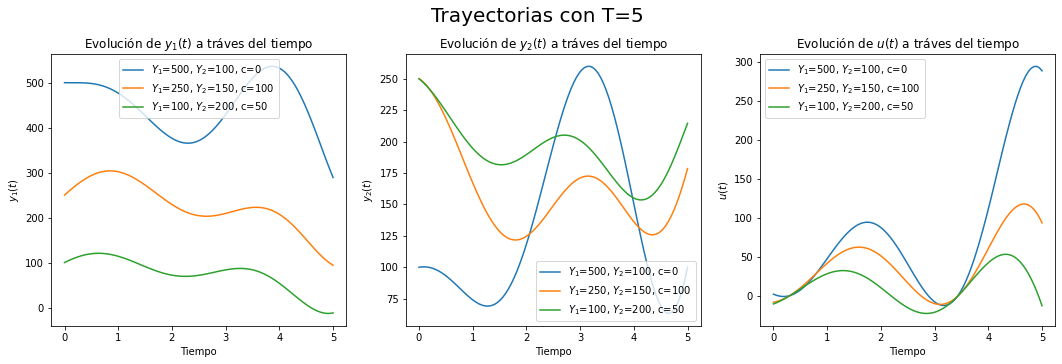

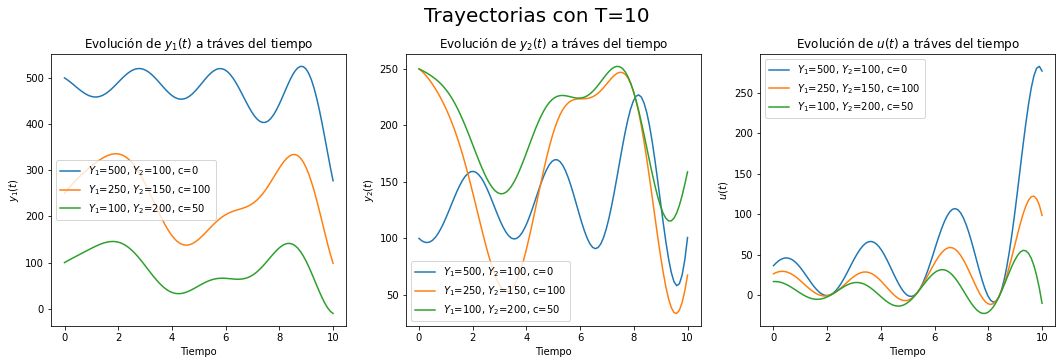

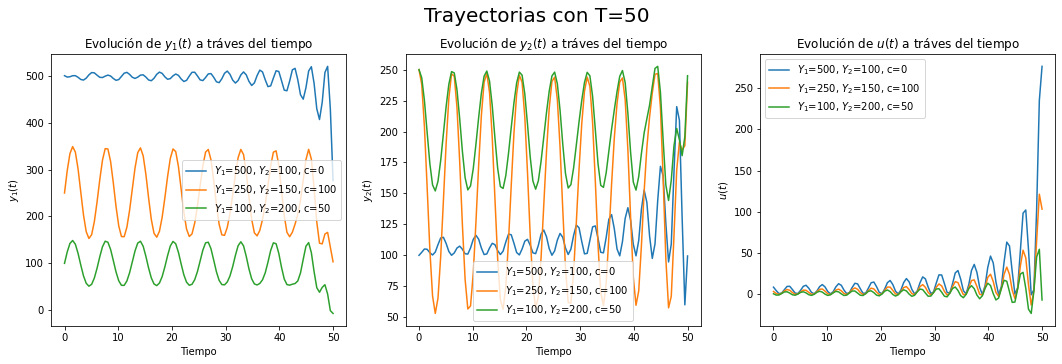

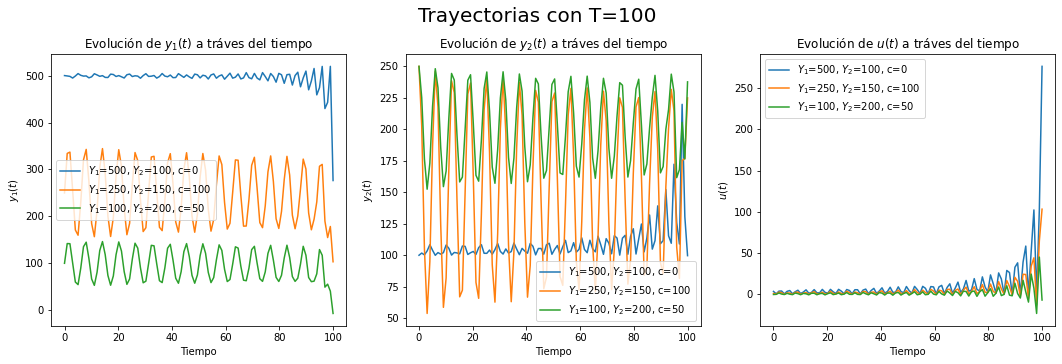

In [9]:
Ts=[5, 10, 50, 100]
constantes=[[500,100,0],[250,150,100],[100,200,50]]

Valores_objetivo={}
for T in Ts:
    soluciones=[]
    V_objetivo=[]
    for Cte in constantes:
        [Y1, Y2, c] = Cte
        [y1, y2, u], E=solver3(T, Y1, Y2, c)
        valor_objetivo=-([y1[0], y2[0]]@E(0)@[y1[0], y2[0]])
        soluciones.append([y1, y2, u])
        V_objetivo.append(valor_objetivo)
    Valores_objetivo['T='+str(T)]=V_objetivo
        
    labels=['y_1(t)', 'y_2(t)', 'u(t)']
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(18,5))
    fig.suptitle(f'Trayectorias con T={T}', fontsize=20, y=1.01) #$p_0$={tuple(p)}
    for i, ax in enumerate(axs):  
        for j in range(len(constantes)):
            [Y1, Y2, c]=constantes[j]
            ax.plot(np.linspace(0,T,100),soluciones[j][i], label=f'$Y_1$={Y1}, $Y_2$={Y2}, c={c}')
            
        ax.set_xlabel('Tiempo')
        ax.set_ylabel(f'${labels[i]}$')
        ax.set_title(f'Evolución de ${labels[i]}$ a tráves del tiempo')
        ax.legend(loc='best')

In [10]:
#Valores de la función objetivo para distintas constantes y tiempos.
df=pd.DataFrame(Valores_objetivo)
df.insert(0, 'Parametros: [Y1, Y2, c]', constantes)
df

,"Parametros: [Y1, Y2, c]",T=5,T=10,T=50,T=100
0,"[500, 100, 0]",680.901498,20463.950216,4212.021659,1677.862603
1,"[250, 150, 100]",4880.566594,10884.669114,777.064101,267.724793
2,"[100, 200, 50]",7488.129311,4438.853508,133.849493,113.675281


In [11]:
Valores_objetivo

{'T=5': [680.9014980846516, 4880.566593980788, 7488.129311163041],
 'T=10': [20463.950216482634, 10884.669114028173, 4438.853507905425],
 'T=50': [4212.021658579964, 777.0641007693131, 133.8494931236655],
 'T=100': [1677.8626032353284, 267.7247930568373, 113.67528087102214]}

# Ejercicio 4

Evolución del sistema con $Y_1=500$, $Y_2=100$, $c=0$, para tiempos $T=5$, $10$, $50$ respectivamente.
<div style="display:flex">
     <div style="flex:1;padding-right:10px;">
          <img src="p4_t5_c1.PNG" width="300"/>
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="p4_t10_c1.PNG" width="300"/>
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="p4_t50_c1.PNG" width="300"/>
     </div>
</div>

<br>

Evolución del sistema con $Y_1=250$, $Y_2=150$, $c=100$, para tiempos $T=5$, $10$, $50$ respectivamente.
<div style="display:flex">
     <div style="flex:1;padding-right:10px;">
          <img src="p4_t5_c2.PNG" width="300"/>
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="p4_t10_c2.PNG" width="300"/>
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="p4_t50_c2.PNG" width="300"/>
     </div>
</div>

<br>

Evolución del sistema con $Y_1=100$, $Y_2=200$, $c=50$, para tiempos $T=5$, $10$, $50$ respectivamente.

<div style="display:flex">
     <div style="flex:1;padding-right:10px;">
          <img src="p4_t5_c3.PNG" width="300"/>
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="p4_t10_c3.PNG" width="300"/>
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="p4_t50_c3.PNG" width="300"/>
     </div>
</div>

# Ejercicio 5

Evolución del sistema con $Y_1=500$, $Y_2=100$, $c=0$, para tiempos $T=5$, $10$, $50$ respectivamente.
<div style="display:flex">
     <div style="flex:1;padding-right:10px;">
          <img src="p5_t5_c1.PNG" width="300"/>
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="p5_t10_c1.PNG" width="300"/>
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="p5_t50_c1.PNG" width="300"/>
     </div>
</div>

<br>

Evolución del sistema con $Y_1=250$, $Y_2=150$, $c=100$, para tiempos $T=5$, $10$, $50$ respectivamente.
<div style="display:flex">
     <div style="flex:1;padding-right:10px;">
          <img src="p5_t5_c2_99.PNG" width="300"/>
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="p5_t10_c2_99.PNG" width="300"/>
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="p5_t50_c2.PNG" width="300"/>
     </div>
</div>

<br>

Evolución del sistema con $Y_1=100$, $Y_2=200$, $c=50$, para tiempos $T=5$, $10$, $50$ respectivamente.
<div style="display:flex">
     <div style="flex:1;padding-right:10px;">
          <img src="p5_t5_c3.PNG" width="300"/>
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="p5_t10_c3.PNG" width="300"/>
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="p5_t50_c3.PNG" width="300"/>
     </div>
</div>